# <center>Validation</center>

<center> <img src = 'https://scikit-learn.org/stable/_images/grid_search_workflow.png' width=80%> </center>

* [`Scikit-Learn` Validation Docs](https://scikit-learn.org/stable/modules/cross_validation.html)

## 1. Types of Validation Techniques

**Main Validation Techniques**
* `KFold` - is a cross-iterator for K-fold validation.
* `StratifiedKFold` - is the same, but also stratified (balanced).
* `GroupKFold` - is a K-fragment iterator with disjoint groups.
* `RepeatedKFold` - K-fold validation with repetitions.

<center> <img src = 'https://scikit-learn.ru/wp-content/uploads/2021/10/image-161.png' width=%90> </center>

**Can be useful too**
* `StratifiedGroupKFold` - it's the same, but also stratified (balanced)
* `RepeatedStratifiedKFold` - and here it's stratified, but additionally with repetitions

* `Shuffle Split` - shuffles all samples first, then divides them into a set number of folds.
* `Time Series Split` - used when the data is ordered by time.
* `Leave One Out (LOO)` - removes only 1 data sample from the dataset for each fold (creates all possible training sets).
* `Leave One Group Out` - the same thing, but removes 1 group of samples each time.
* `Leave P Out` - removes P samples from the dataset and creates all possible sets, the values in the sets can be repeated.

**Which one to use and when:**
- Is there a temporary dependence?  
=>> `TimeSeriesSplit`
- Little data and learning fast?  
=>> `LeaveOneOut` 
- A lot of data, but learning fast?  
=>> `KFold`
- Does it take a lot of data and a long time to learn?  
=>> `train_test_split()`
- Is there a class imbalance?  
=>> Any iterator with the prefix `Stratified`
- There are groups and it is impossible to allow their simultaneous presence in `train` and `test`?  
=>> Any iterator with the prefix `Group` will do the thing.

## 2. Import Libraries

In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_columns", None)

from classes import Paths

## 3. Load Datasets

In [2]:
paths = Paths()
train = pd.read_csv(paths.car_train)
test = pd.read_csv(paths.car_test)
display("train", train.sample(4))
display("test", test.sample(4))

'train'

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
915,Q70371595z,Hyundai Solaris,economy,petrol,2.32,2015,73471,2021,29.55,gear_stick
579,l-1554787I,Renault Sandero,standart,petrol,4.48,2011,3678,2018,134.49,another_bug
438,Z16147645X,Skoda Rapid,economy,petrol,3.70,2015,81430,2021,26.61,engine_fuel
1641,Z-4890116p,Kia Sportage,standart,petrol,4.20,2013,40086,2018,39.47,engine_fuel


'test'

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
1631,l-2092770w,Nissan Qashqai,standart,petrol,4.60,2014,64478,2019
1540,a-1327017v,Smart ForFour,economy,petrol,5.76,2013,40551,2016
1188,m-2234361C,Skoda Rapid,economy,petrol,5.18,2016,107416,2018
1420,B-6097000E,Smart Coupe,economy,petrol,4.54,2015,87638,2017


## 4. Basic `Feature Engineering` - generate and add new features

In [3]:
rides = pd.read_csv(paths.rides_info)
rides.sample(4)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
366158,y10409096b,a-1602414F,W1v,2020-02-03,4.95,11,172,41,47.00,1,321.50,0,3.81,-9.20
121721,b11707150D,I14877267r,f1o,2020-02-20,4.96,99,983,31,66.00,2,1376.62,0,-27.90,-5.59
377051,b21856201r,a56690336a,P1m,2020-03-29,0.51,48,379,37,91.31,0,1866.46,0,-36.17,-14.62
322454,R65130406X,W78003964P,j1J,2020-01-18,6.36,29434,235466,69,87.74,0,2079315.47,0,3.07,0.00


In [4]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby("car_id", as_index=False).agg(
    mean_rating=("rating", "mean"),
    distance_sum=("distance", "sum"),
    rating_min=("rating", "min"),
    speed_msx=("speed_max", "max"),
    user_ride_quality_median=("user_ride_quality", "median"),
    deviation_normal_count=("deviation_normal", "count"),
    user_uniq=("user_id", f),
)

rides_df_gr.head(4)

,car_id,mean_rating,distance_sum,rating_min,speed_msx,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1049127W,4.26,11257529.31,0.10,179.73,-0.29,174,172
1,A-1079539w,4.09,19127650.50,0.10,184.51,2.51,174,173
2,A-1162143G,4.66,2995193.85,0.10,180.00,0.64,174,172
3,A-1228282M,4.23,17936850.54,0.10,182.45,-15.66,174,174


In [5]:
def add_features(df):
    if "mean_rating" not in df.columns:
        df = pd.merge(df
                      , rides_df_gr
                      , on="car_id"
                      , how="left")
    return df

train = add_features(train)
test = add_features(test)
display(train.sample(4))
display(test.sample(4))

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_msx,user_ride_quality_median,deviation_normal_count,user_uniq
2049,q96758261e,Smart ForFour,economy,petrol,4.54,2013,38871,2017,77.91,engine_check,4.79,10795345.10,0.39,153.34,1.68,174,174
1875,t-3165089E,Kia Rio,economy,petrol,5.40,2012,18634,2016,44.99,engine_fuel,4.00,11165046.66,0.10,156.09,14.09,174,174
900,e-2200514f,Kia Rio,economy,petrol,5.98,2013,44604,2019,48.97,engine_ignition,4.25,21276298.95,0.10,177.92,-3.74,174,174
1344,y-1494852A,Hyundai Solaris,economy,petrol,4.04,2013,46673,2018,39.27,engine_fuel,4.06,16317876.61,0.10,172.71,0.83,174,174


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_msx,user_ride_quality_median,deviation_normal_count,user_uniq
367,Z-1497483y,Nissan Qashqai,standart,petrol,4.50,2012,35748,2019,4.77,13529050.49,0.24,165.00,3.93,174,170
1490,O-3470382z,Kia Rio,economy,petrol,5.10,2013,37276,2021,4.51,12075078.35,0.10,142.56,-3.52,174,169
268,I-2189520Y,Nissan Qashqai,standart,petrol,5.86,2012,25686,2017,4.41,14986588.95,0.10,189.80,-20.07,174,172
746,w13418612e,Kia Sportage,standart,petrol,4.28,2011,4,2014,4.07,22837459.33,0.10,173.85,-2.22,174,171


## 5. Encode categorical features (o-h-e)

In [6]:
# cat_features = ["car_type", "fuel_type", "model"]
cat_features = list(test.select_dtypes("O").columns)
cat_features.pop(0)

train = pd.get_dummies(train, columns=cat_features)
test = pd.get_dummies(test, columns=cat_features)

train.head(4)

,car_id,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_msx,user_ride_quality_median,deviation_normal_count,user_uniq,model_Audi A3,model_Audi A4,model_Audi Q3,model_BMW 320i,model_Fiat 500,model_Hyundai Solaris,model_Kia Rio,model_Kia Rio X,model_Kia Rio X-line,model_Kia Sportage,model_MINI CooperSE,model_Mercedes-Benz E200,model_Mercedes-Benz GLC,model_Mini Cooper,model_Nissan Qashqai,model_Renault Kaptur,model_Renault Sandero,model_Skoda Rapid,model_Smart Coupe,model_Smart ForFour,model_Smart ForTwo,model_Tesla Model 3,model_VW Polo,model_VW Polo VI,model_VW Tiguan,model_Volkswagen ID.4,car_type_business,car_type_economy,car_type_premium,car_type_standart,fuel_type_electro,fuel_type_petrol
0,y13744087j,3.78,2015,76163,2021,108.53,another_bug,4.74,12141310.41,0.10,180.86,0.02,174,170,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
1,O41613818T,3.90,2015,78218,2021,35.20,electro_bug,4.48,18039092.84,0.00,187.86,12.31,174,174,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True
2,d-2109686j,6.30,2012,23340,2017,38.62,gear_stick,4.77,15883659.43,0.10,102.38,2.51,174,173,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True
3,u29695600e,4.04,2011,1263,2020,30.34,engine_fuel,3.88,16518828.77,0.10,172.79,-5.03,174,170,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True


## 6. Classify features

In [7]:
features2drop = ["car_id", "target_reg"]  # То, что можно выбросить
targets = ["target_class", "target_reg"]  # Таргеты
cat_features = ["car_type", "fuel_type", "model"]

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print("cat_features :", len(cat_features), cat_features)
print("num_features :", len(num_features), num_features)
print("targets", targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 43 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_msx', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq', 'model_Audi A3', 'model_Audi A4', 'model_Audi Q3', 'model_BMW 320i', 'model_Fiat 500', 'model_Hyundai Solaris', 'model_Kia Rio', 'model_Kia Rio X', 'model_Kia Rio X-line', 'model_Kia Sportage', 'model_MINI CooperSE', 'model_Mercedes-Benz E200', 'model_Mercedes-Benz GLC', 'model_Mini Cooper', 'model_Nissan Qashqai', 'model_Renault Kaptur', 'model_Renault Sandero', 'model_Skoda Rapid', 'model_Smart Coupe', 'model_Smart ForFour', 'model_Smart ForTwo', 'model_Tesla Model 3', 'model_VW Polo', 'model_VW Polo VI', 'model_VW Tiguan', 'model_Volkswagen ID.4 ', 'car_type_business', 'car_type_economy', 'car_type_premium', 'car_type_standart', 'fuel_type_electro', 'fuel_type_petrol']
targets ['target_class', 'target_reg']


## 7. Train Random Forest with K-Fold validation

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold

In [9]:
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train[["target_class"]]



In [10]:
# adhoc
n_splits = 5
clfs = []
scores = []
# validation parameters, training process will be done with n_splits (folds)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=21)

a = kf.split(X,y)

for c, d in enumerate(a):
    print(c, d[0])

# for c, d in enumerate(a):
#     print(c, d[1])

0 [   0    1    2 ... 2334 2335 2336]
1 [   0    2    3 ... 2332 2333 2336]
2 [   0    1    2 ... 2333 2334 2335]
3 [   0    1    3 ... 2334 2335 2336]
4 [   1    2    3 ... 2334 2335 2336]


In [11]:
n_splits = 5
clfs = []
scores = []

# validation parameters, training process will be done with n_splits (folds)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=21)

for num, (train_index, test_index) in enumerate(kf.split(X)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf = RandomForestClassifier(
        n_estimators=2_000,
        min_samples_leaf=4,
        n_jobs=-1,
        max_features=0.60,
        # class_weight = 'balanced',
        random_state=7575,
        max_depth=6,
    )

    clf.fit(X_train, y_train["target_class"])
    clfs.append(clf)  # save model for further usage (predictions)

    y_pred = clf.predict(X_test)
    score = np.mean(np.array(y_pred == y_test["target_class"]))
    scores.append(score)
    print(f"fold: {num} acc: {score}")

print(f"Number of classifiers: {len(clfs)}")
print(f"Number of splits: {n_splits}")
assert len(clfs) == n_splits  # check that we have all models

# calculate mean accuracy score and its std
print("mean accuracy score --", np.mean(scores, dtype="float16"), np.std(scores).round(4))

fold: 0 acc: 0.8376068376068376
fold: 1 acc: 0.8034188034188035
fold: 2 acc: 0.7944325481798715
fold: 3 acc: 0.7708779443254818
fold: 4 acc: 0.8115631691648822
Number of classifiers: 5
Number of splits: 5
mean accuracy score -- 0.803 0.0218


## 8. Feature Importance

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid"
      , palette="muted"
      , color_codes=True)

43 features averaged by 5 models: 
Top-43 features illustrated on graph


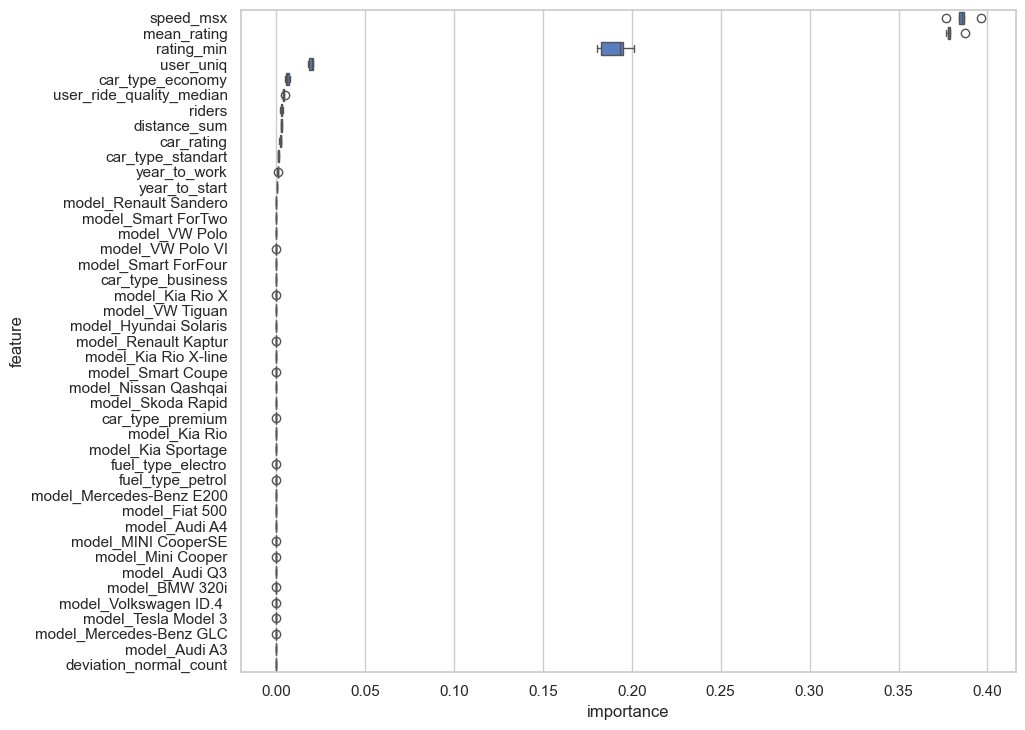

In [13]:
def plot_importance(df, best_model, height, top_n=50):

    top_n = min(top_n, df.shape[1])

    # retrieve feature importances from models
    fi = pd.DataFrame(index=df.columns, columns=[])
    for i, m in enumerate(best_model):
        fi[f"m_{i}"] = m.feature_importances_

    fi = fi.stack().reset_index().iloc[:, [0, 2]]
    fi.columns = ["feature", "importance"]

    # Define feature order and select only top_n features
    cols_ord = (
        fi.groupby("feature")["importance"]
        .mean()
        .sort_values(ascending=False)
        .index.tolist()[:top_n]
    )

    fi = fi[fi["feature"].isin(cols_ord)]  # Order by importance value
    print( "{} features averaged by {} models: ".format(len(cols_ord), len(best_model)))

    # Plot boxplots of featres importance
    plt.figure(figsize=(10, len(cols_ord) * height))
    b = sns.boxplot(data=fi, y="feature", x="importance", orient="h", order=cols_ord)

    print("Top-{} features illustrated on graph".format(top_n))
    return (
        fi.groupby(by=["feature"], as_index=False)["importance"]
        .mean()
        .sort_values(by="importance", ascending=False)
    )


df_feats_imp = plot_importance(
    train[filtered_features].drop(targets, axis=1, errors="ignore"),
    clfs,
    0.20,
    top_n=100,
)

<div class="alert alert-info">
    
**To summarize:**

* Different validations diversify the model
* Validation speeds up hypothesis testing
* `К-Fold` validation gives you unbiased estimate of the metric value
* If there are problems in the formulation of the problem or data - you will find out about it immediately
* Not all types of validation can be configured for any data size